# Import  
파이썬에서 다른 모듈이나 패키지에서 함수, 클래스 등을 가져옵니다.

In [15]:
!pip install koreanize-matplotlib
import koreanize_matplotlib


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: C:\Users\HOME\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler,StandardScaler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

#### 시드(seed) 고정  
매번 고정된 결과를 얻기 위해서 사용합니다.  
시드를 고정하지 않는다면 같은 코드라도 매번 다른 결과가 나올 수 있습니다.

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

#### 데이터 읽어오기 및 데이터 확인

In [4]:
# pd.read_csv() 함수를 사용해서 데이터를 읽어오는 코드입니다.
train = pd.read_csv('C:/Users/HOME/Downloads/범죄분류데이터/train.csv')

# 데이터를 확인하기 위해 head() 함수를 사용합니다.
train.head()

,ID,월,요일,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지,TARGET
0,TRAIN_00000,9,화요일,10,137,8.0,2.611124,0.000,0.0,0.0,245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,2
1,TRAIN_00001,11,화요일,6,438,13.0,3.209093,0.000,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,0
2,TRAIN_00002,8,일요일,6,1729,47.0,1.619597,0.000,0.0,0.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,인도,1
3,TRAIN_00003,5,월요일,6,2337,53.0,1.921615,11.375,0.0,0.0,225.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,주거지,1
4,TRAIN_00004,9,일요일,11,1439,41.0,1.789721,0.000,0.0,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,주유소,2


#### 독립변수(x_train), 종속변수(y_train)로 분리하기  


In [5]:
x_train = train.drop(['ID', 'TARGET'], axis = 1)
y_train = train['TARGET']


#### train , validation data 나누기

In [7]:
X_tr, X_val, Y_tr, Y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

#### 라벨인코딩(Label Encoding)

In [8]:

ordinal_features = ['요일', '범죄발생지']

for feature in ordinal_features:
    le = LabelEncoder()

    # Fit and transform on the training data
    le = le.fit(X_tr[feature])
    X_tr[feature] = le.transform(X_tr[feature])

    # Transform the test data (Note: Only transform, do not fit again to avoid data leakage)
    X_val[feature] = le.transform(X_val[feature])



### LightGBM

In [17]:
model = lgb.LGBMClassifier(random_state=42)
model.fit(X_tr, Y_tr)

y_pred = model.predict(X_val)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 59084, number of used features: 18
[LightGBM] [Info] Start training from score -0.838949
[LightGBM] [Info] Start training from score -1.202293
[LightGBM] [Info] Start training from score -1.319267


#### 예측

정확도 : 0.5533
정말도 : 0.5508
Recall: 0.5533
F1 Score: 0.5426
Confusion Matrix:
[[8033 1284 1602]
 [3028 3374 1240]
 [3125 1032 2604]]


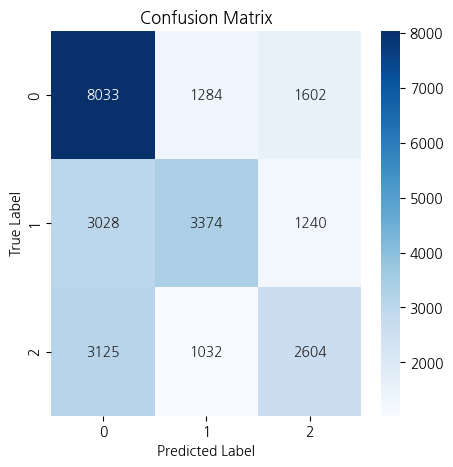

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

acc=accuracy_score(Y_val,y_pred)
print(f'정확도 : {acc:.4f}')

# 정밀도 (precision)
precision=precision_score(Y_val,y_pred, average='weighted')
print(f'정말도 : {precision:.4f}')

recall = recall_score(Y_val, y_pred, average='weighted')
print(f'Recall: {recall:.4f}')

# F1 점수 (F1 Score)
f1 = f1_score(Y_val, y_pred, average='weighted')
print(f'F1 Score: {f1:.4f}')

# 혼동 행렬 (Confusion Matrix)
conf_matrix = confusion_matrix(Y_val, y_pred)
print('Confusion Matrix:')
print(conf_matrix)


plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

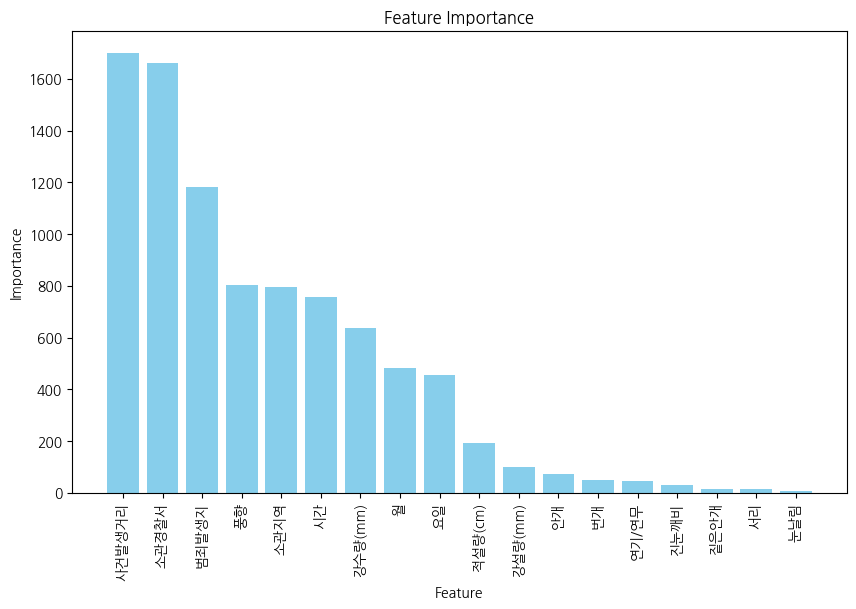

In [19]:
importances=model.feature_importances_

feature_importance_df=pd.DataFrame({'Feature':X_tr.columns,'Importance':importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()

#### Sampling

##### 오버샘플링

In [11]:
ros=RandomUnderSampler(random_state=42)
x_tr_over,y_tr_over=ros.fit_resample(X_tr,Y_tr)


In [12]:
model = lgb.LGBMClassifier(random_state=42)
model.fit(x_tr_over,y_tr_over)

y_pred = model.predict(X_val)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 47385, number of used features: 18
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


정확도 : 0.5494
정말도 : 0.5468
Recall: 0.5494
F1 Score: 0.5469
Confusion Matrix:
[[7127 1835 1957]
 [2281 3829 1532]
 [2645 1160 2956]]


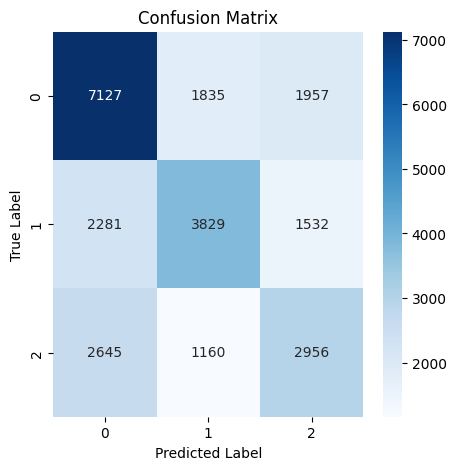

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

acc=accuracy_score(Y_val,y_pred)
print(f'정확도 : {acc:.4f}')

# 정밀도 (precision)
precision=precision_score(Y_val,y_pred, average='weighted')
print(f'정말도 : {precision:.4f}')

recall = recall_score(Y_val, y_pred, average='weighted')
print(f'Recall: {recall:.4f}')

# F1 점수 (F1 Score)
f1 = f1_score(Y_val, y_pred, average='weighted')
print(f'F1 Score: {f1:.4f}')

# 혼동 행렬 (Confusion Matrix)
conf_matrix = confusion_matrix(Y_val, y_pred)
print('Confusion Matrix:')
print(conf_matrix)


plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [15]:
# 샘플링 과정이 없던 모델보다 성능이 좋은 것 확인
# 가장 분류가 안되었던 class 3이 이전 모델보다 훨씬 많이 분류되었음

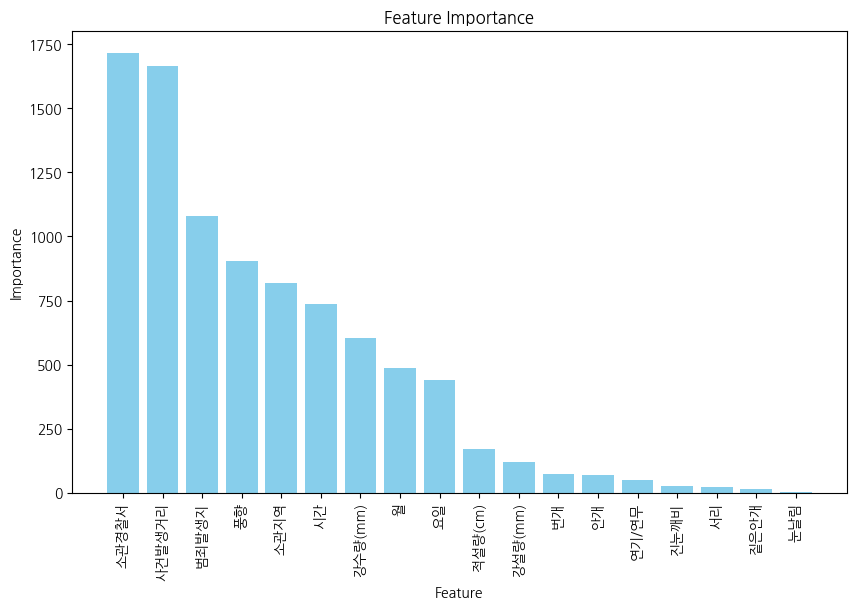

In [16]:
importances=model.feature_importances_

feature_importance_df=pd.DataFrame({'Feature':X_tr.columns,'Importance':importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()

##### SMOTE

In [20]:
smote=SMOTE(random_state=42)
x_tr_smote,y_tr_smote=smote.fit_resample(X_tr,Y_tr)

In [21]:
model = lgb.LGBMClassifier(random_state=42)
model.fit(x_tr_smote,y_tr_smote)

y_pred = model.predict(X_val)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3172
[LightGBM] [Info] Number of data points in the train set: 76602, number of used features: 18
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


정확도 : 0.5497
정말도 : 0.5466
Recall: 0.5497
F1 Score: 0.5440
Confusion Matrix:
[[7533 1500 1886]
 [2632 3572 1438]
 [2830 1117 2814]]


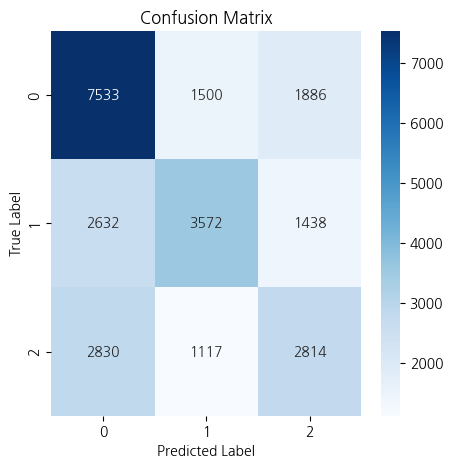

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

acc=accuracy_score(Y_val,y_pred)
print(f'정확도 : {acc:.4f}')

# 정밀도 (precision)
precision=precision_score(Y_val,y_pred, average='weighted')
print(f'정말도 : {precision:.4f}')

recall = recall_score(Y_val, y_pred, average='weighted')
print(f'Recall: {recall:.4f}')

# F1 점수 (F1 Score)
f1 = f1_score(Y_val, y_pred, average='weighted')
print(f'F1 Score: {f1:.4f}')

# 혼동 행렬 (Confusion Matrix)
conf_matrix = confusion_matrix(Y_val, y_pred)
print('Confusion Matrix:')
print(conf_matrix)


plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

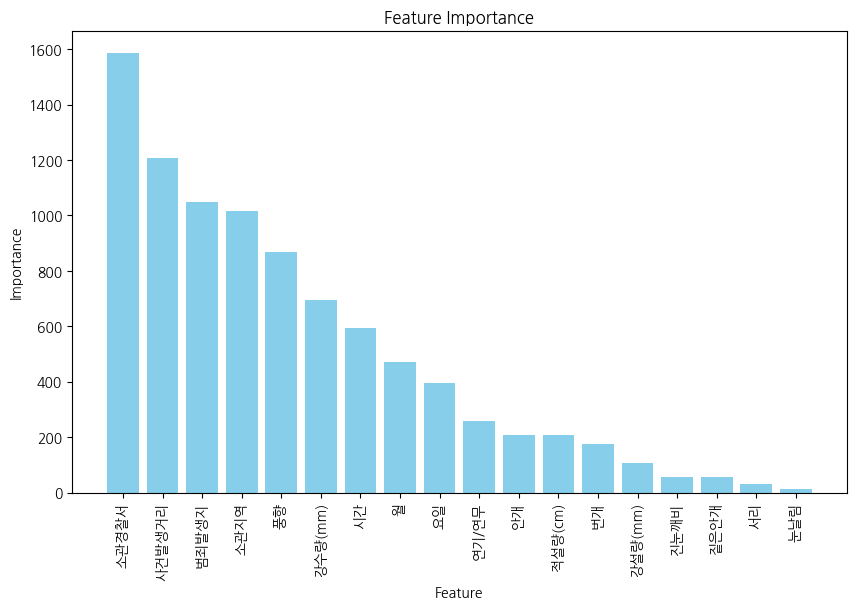

In [23]:
importances=model.feature_importances_

feature_importance_df=pd.DataFrame({'Feature':X_tr.columns,'Importance':importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()

##### 언더샘플링

In [24]:
rus=RandomUnderSampler(random_state=42)
x_tr_under,y_tr_under=rus.fit_resample(X_tr,Y_tr)

In [25]:
model = lgb.LGBMClassifier(random_state=42)
model.fit(x_tr_under,y_tr_under)

y_pred = model.predict(X_val)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 918
[LightGBM] [Info] Number of data points in the train set: 47385, number of used features: 18
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


정확도 : 0.5494
정말도 : 0.5468
Recall: 0.5494
F1 Score: 0.5469
Confusion Matrix:
[[7127 1835 1957]
 [2281 3829 1532]
 [2645 1160 2956]]


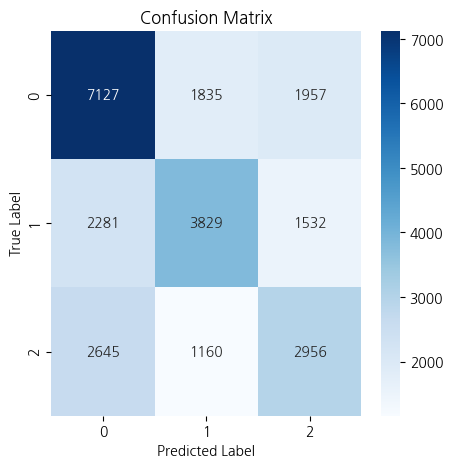

In [26]:

acc=accuracy_score(Y_val,y_pred)
print(f'정확도 : {acc:.4f}')

# 정밀도 (precision)
precision=precision_score(Y_val,y_pred, average='weighted')
print(f'정말도 : {precision:.4f}')

recall = recall_score(Y_val, y_pred, average='weighted')
print(f'Recall: {recall:.4f}')

# F1 점수 (F1 Score)
f1 = f1_score(Y_val, y_pred, average='weighted')
print(f'F1 Score: {f1:.4f}')

# 혼동 행렬 (Confusion Matrix)
conf_matrix = confusion_matrix(Y_val, y_pred)
print('Confusion Matrix:')
print(conf_matrix)


plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# 샘플링 적용 시, 언더샘플링 방법이 가장 좋음
# feature_impotance를 봤을 때,다른 모델에 비해 여러 변수들의 영향 받고 있는 것을 알수 있음